In [1]:
import wandb
import pandas as pd
from functools import cache

api = wandb.Api()

In [2]:
import numpy as np
entity = 'rh-iu'

symjepa_project = 'symjepa'
symjepa_main_run = '8yrvvx5n'

def get_run(entity, project, run_id):
    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")

    return run

@cache
def run_metric(run_id, metric_name, project=symjepa_project):
    run = get_run(entity, project, run_id)
    if not run:
        raise ValueError(f"Run with ID {run_id} not found in project {symjepa_project}.")
    return run.scan_history(keys=[metric_name])




In [3]:
import matplotlib.pyplot as plt

def make_plot(title, x_label, y_label, metrics, labels, filename):
    # plt.rc('font', family='sans-serif')  # Example: 'serif', 'sans-serif', 'monospace'
    plt.rc('font', size=12)         # Set global font size (adjust as necessary)

    # Alternatively, set a specific font (e.g., Times New Roman)
    plt.rc('font', family='serif')
    # Create the plot with enhanced aesthetics for a research paper
    plt.figure(figsize=(12, 6))  # Set figure size for better readability

    plt.rcParams.update({
        "axes.prop_cycle": plt.cycler(
            # linestyle=['-', '--', '-.', ':', '-', '--', '-.', ':'],
            linestyle=['-', '-', '--', '--', '-.', '-.', ':', ':'],
            color=['black', '0.7'] * 4  # All black for grayscale printing
        ),
        "lines.linewidth": 2,
        "lines.markersize": 6
    })

    # print([x for x in pretraining_results])
    for metric, label in zip(metrics, labels):
        plt.plot(metric,
                 label=label)
    # plt.plot( [x['train_loss'] for x in run_metric(pretraining_results, 'train_loss')], label='Train Loss')

    # Adding titles and labels with improved formatting
    # plt.title('Validation Loss vs. Steps', fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    # Improve tick readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a grid for better visual clarity
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add a legend
    # plt.legend(loc='best', fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    # Tight layout to prevent clipping
    plt.title(title, fontsize=16)
    plt.legend(loc='best', fontsize=12)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

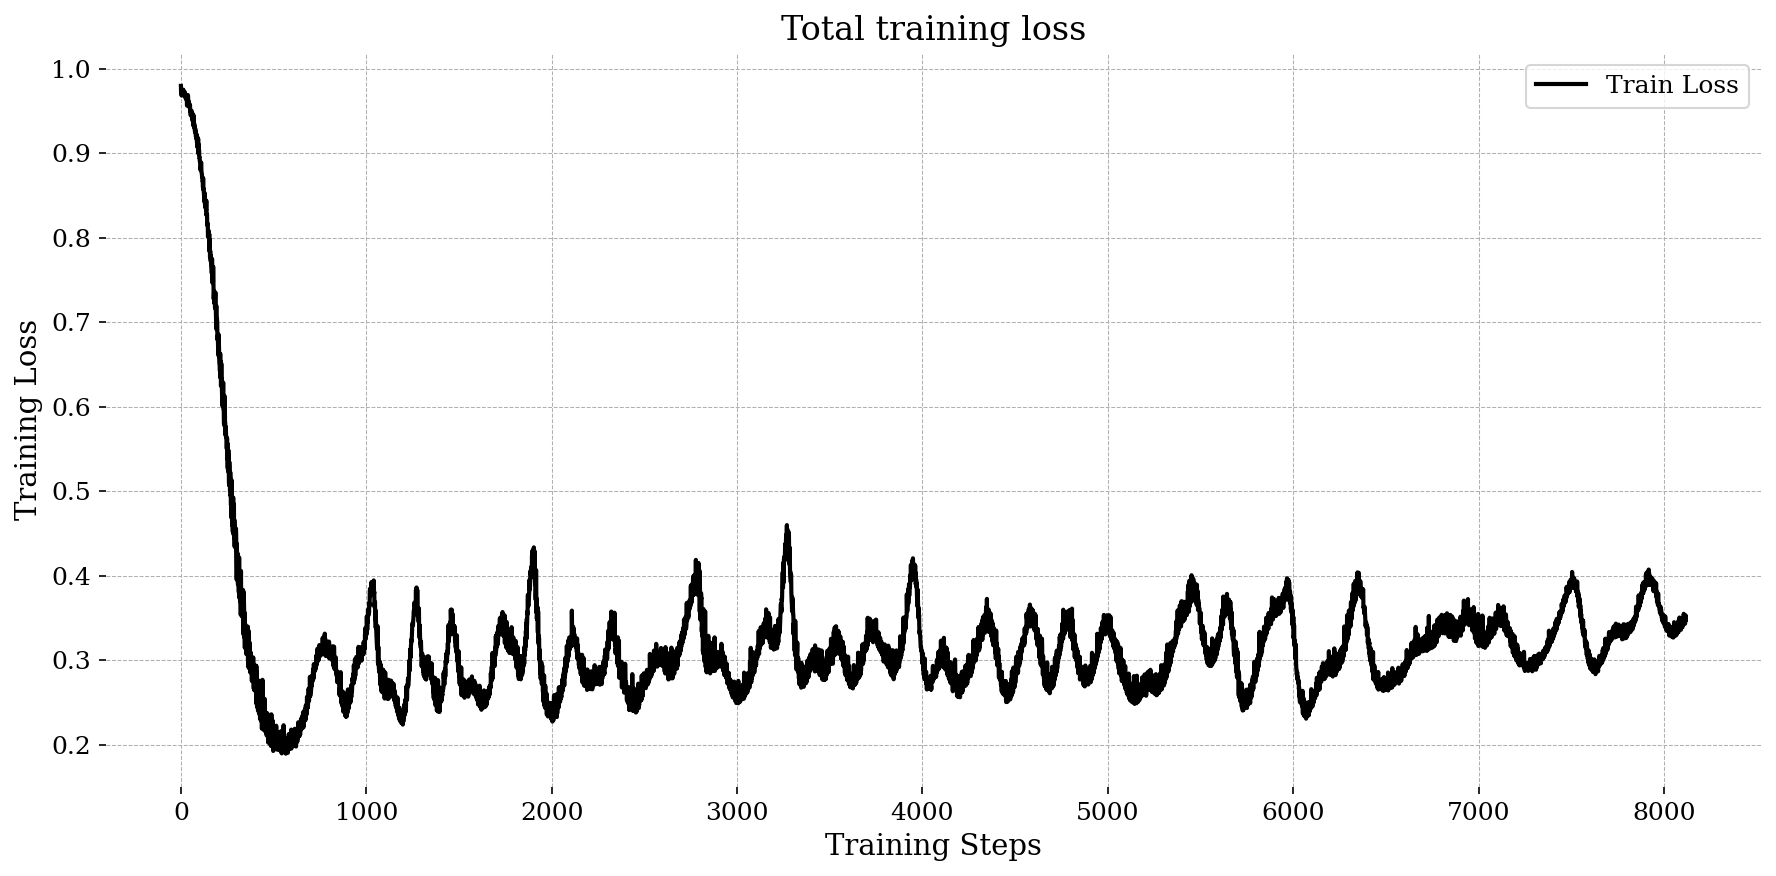

In [28]:
train_loss = np.array([x['train_loss'] for x in run_metric(symjepa_main_run, 'train_loss')])

make_plot(
    title="Total training loss",
    x_label='Training Steps',
    y_label='Training Loss',
    metrics=[train_loss],
    labels=['Train Loss'],
    filename='train_loss.pdf'
)

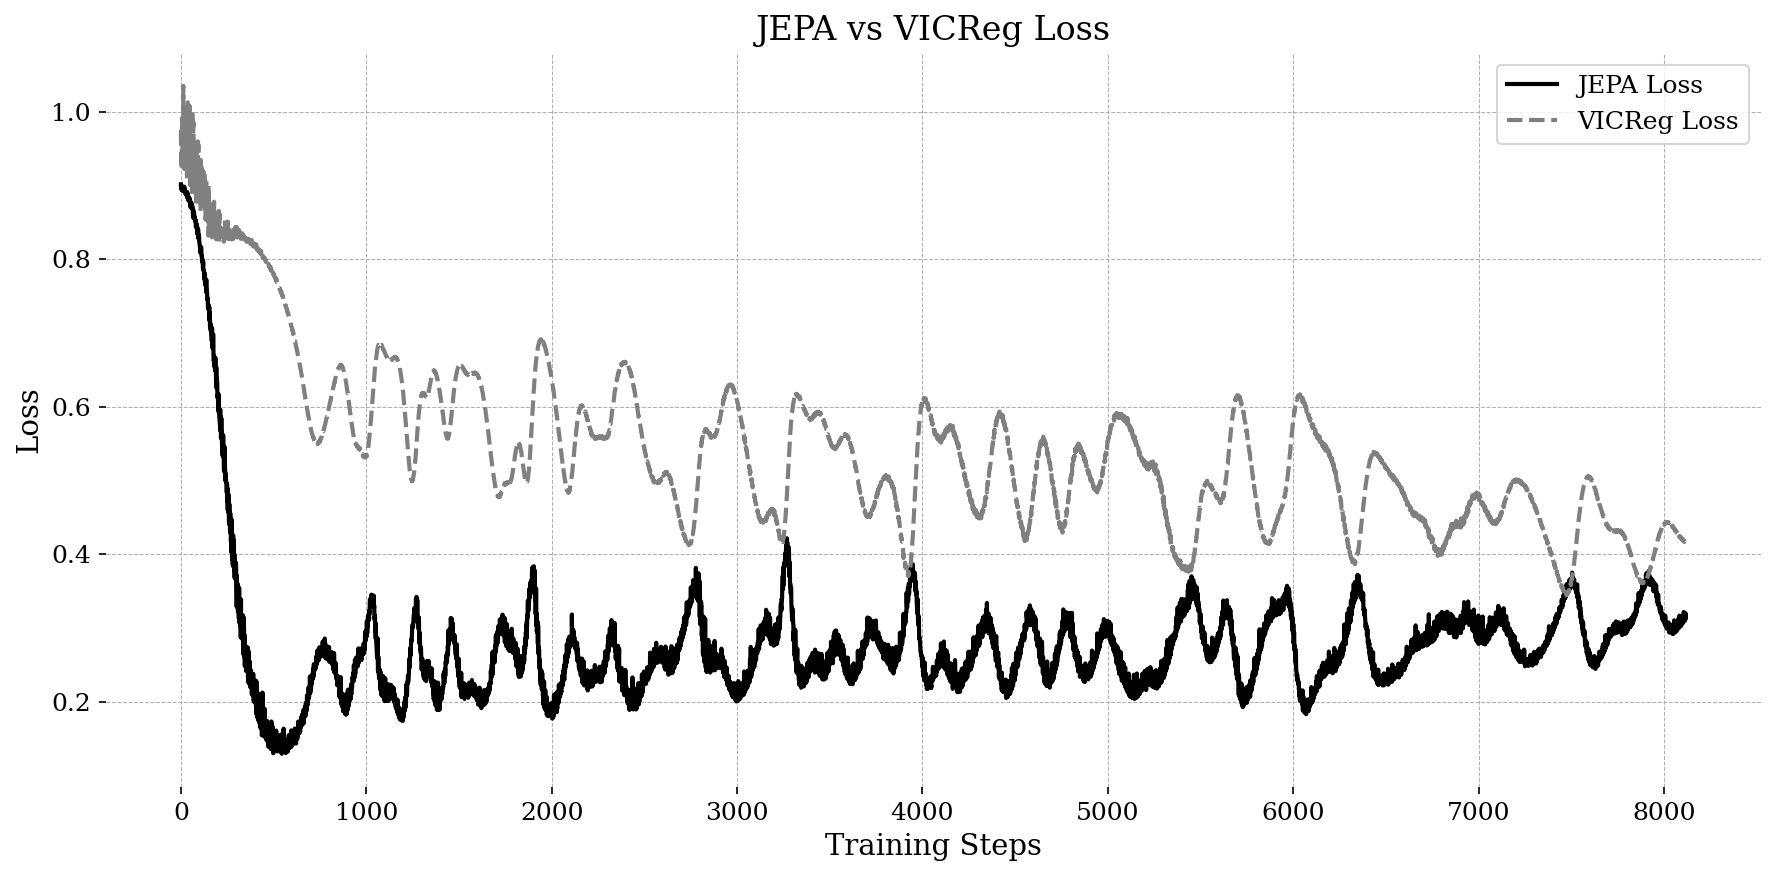

In [ ]:
train_jepa_loss = np.array([x['train_jepa_loss'] for x in run_metric(symjepa_main_run, 'train_jepa_loss')])
train_vicreg_loss = np.array([x['train_vicreg_loss'] for x in run_metric(symjepa_main_run, 'train_vicreg_loss')])

make_plot(
    title="JEPA vs VICReg Loss",
    x_label='Training Steps',
    y_label='Loss',
    metrics=[train_jepa_loss, train_vicreg_loss*0.025],
    labels=['JEPA Loss', 'VICReg Loss'],
    filename='jepa_vs_vicreg_loss.pdf',
)

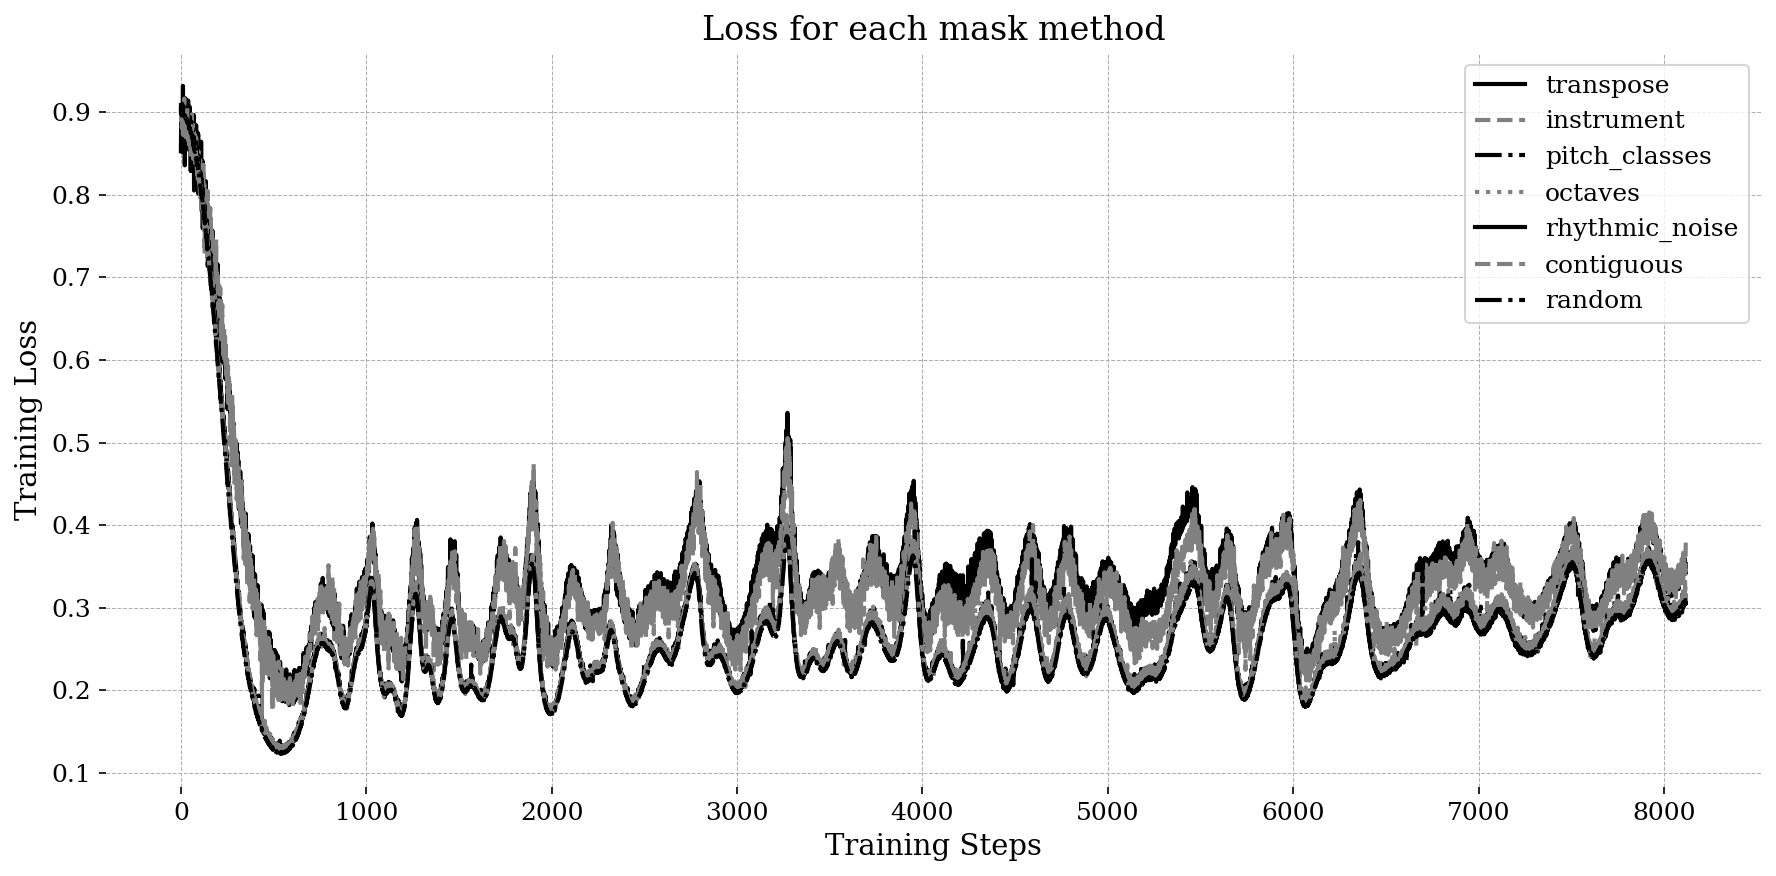

In [29]:
mask_methods = ['transpose', 'instrument', 'pitch_classes', 'octaves', 'rhythmic_noise', 'contiguous', 'random']

metrics = [
    np.array([x[f'train_mask_method_loss_{m}'] for x in run_metric(symjepa_main_run, f'train_mask_method_loss_{m}')])
    for m in mask_methods
]

make_plot(
    title="Loss for each mask method",
    x_label='Training Steps',
    y_label='Training Loss',
    metrics=metrics,
    labels=mask_methods,
    filename='masking_methods.pdf'
)

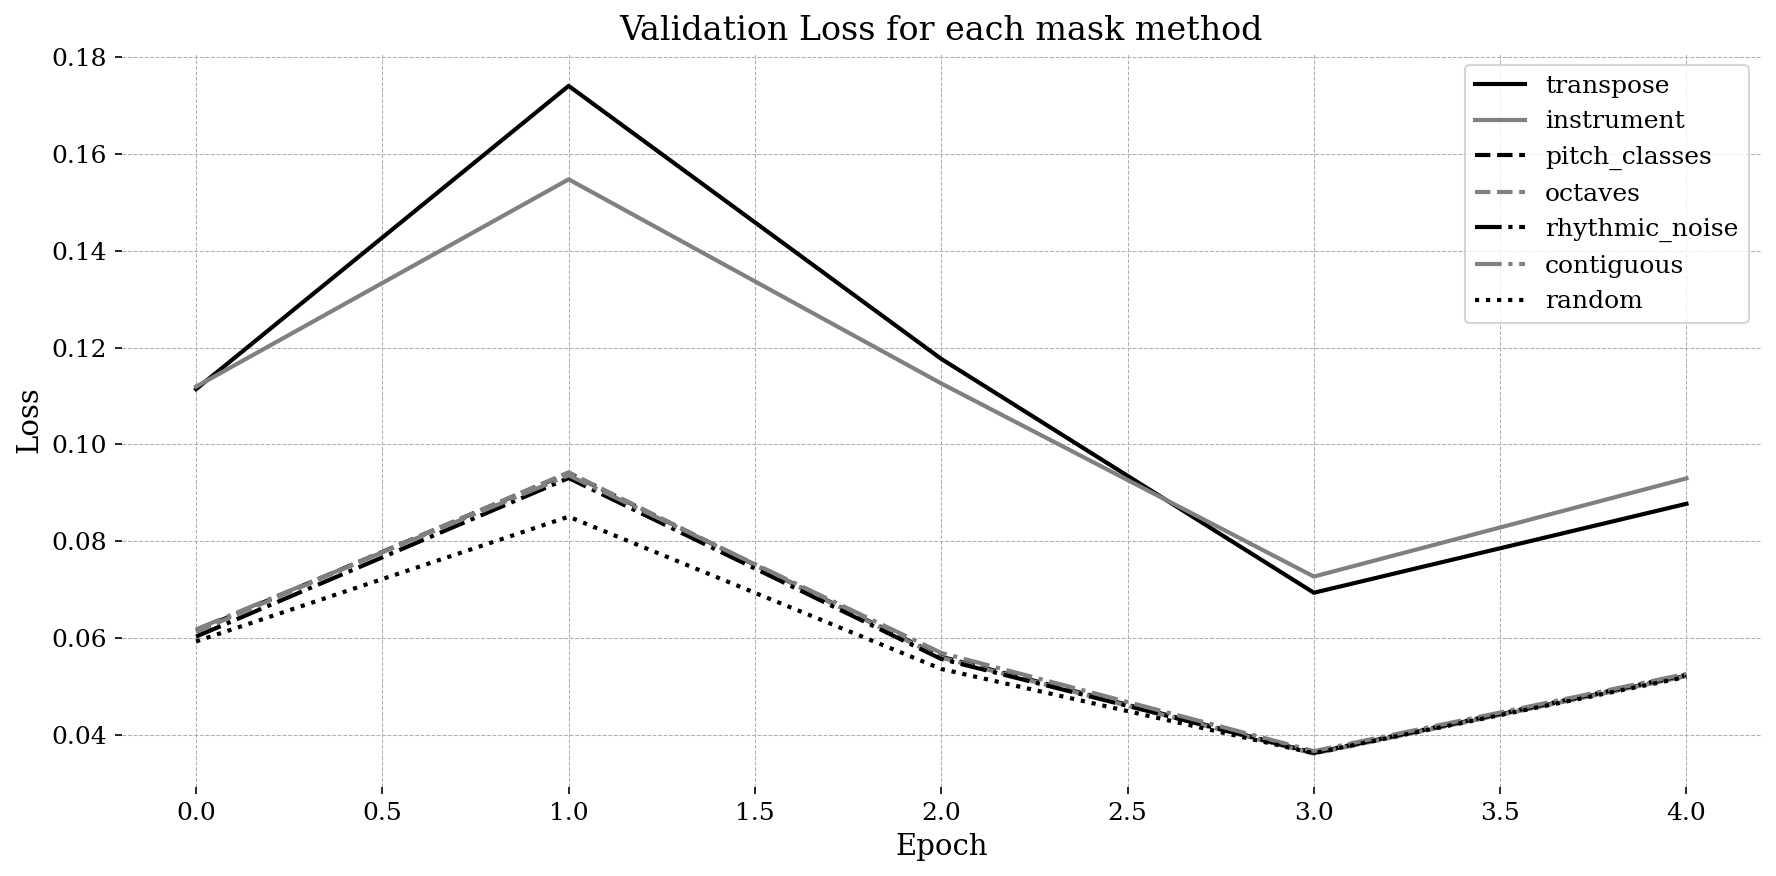

In [32]:
mask_methods = ['transpose', 'instrument', 'pitch_classes', 'octaves', 'rhythmic_noise', 'contiguous', 'random']

metrics = [
    np.array([x[f'val_mask_method_loss_{m}'] for x in run_metric(symjepa_main_run, f'val_mask_method_loss_{m}')])
    for m in mask_methods
]


averaged_metrics = [np.array([segment.mean() for segment in np.array_split(arr, 5)]) for arr in metrics]
make_plot(
    title="Validation Loss for each mask method",
    x_label='Epoch',
    y_label='Loss',
    metrics=averaged_metrics,
    labels=mask_methods,
    filename='val_mask_methods.pdf',
)

## Downstream

In [4]:
best_melody = 'pqojnn4e'
best_acc = '375urf34'

main_jepa_lowest_first_epoch_val_loss = '1cnnl70a'



melody_untrained = 'ax5a448o'

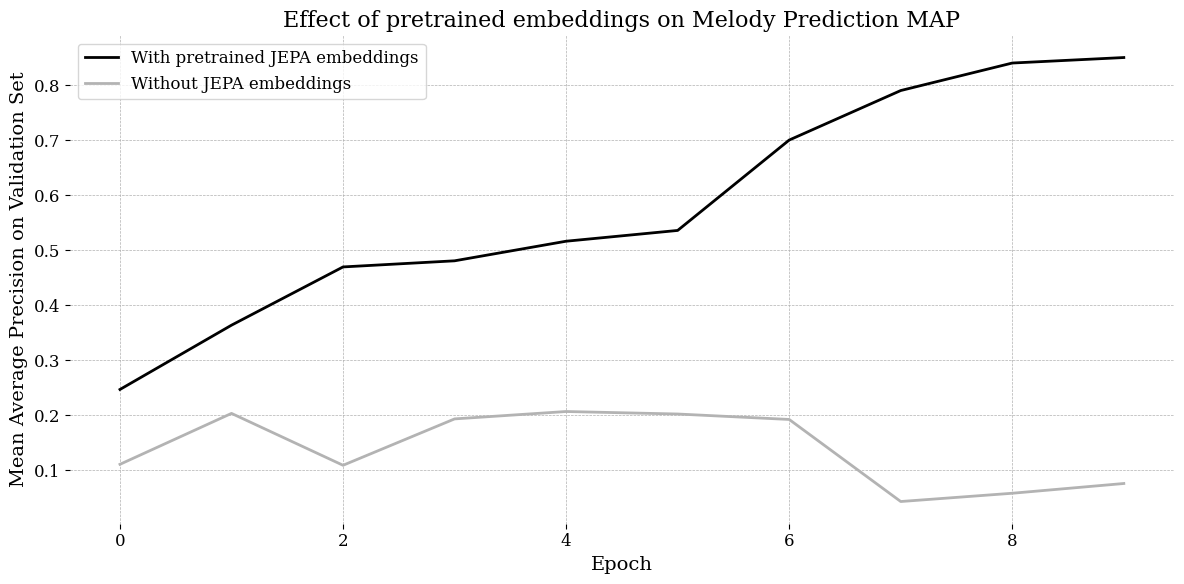

In [11]:
best_melody_map = [x['val_map'] for x in run_metric(best_melody, 'val_map', project='symjepa-melody_completion-classification')] + [0.70, 0.79, 0.84, 0.85]
untrained = [x['val_map'] for x in run_metric(melody_untrained, 'val_map', project='symjepa-melody_completion-classification')]


make_plot(
    title="Effect of pretrained embeddings on Melody Prediction MAP",
    x_label='Epoch',
    y_label='Mean Average Precision on Validation Set',
    metrics=[best_melody_map, untrained],
    labels=['With pretrained JEPA embeddings', 'Without JEPA embeddings'],
    filename='melody_trained_vs_untrained.pdf',
)

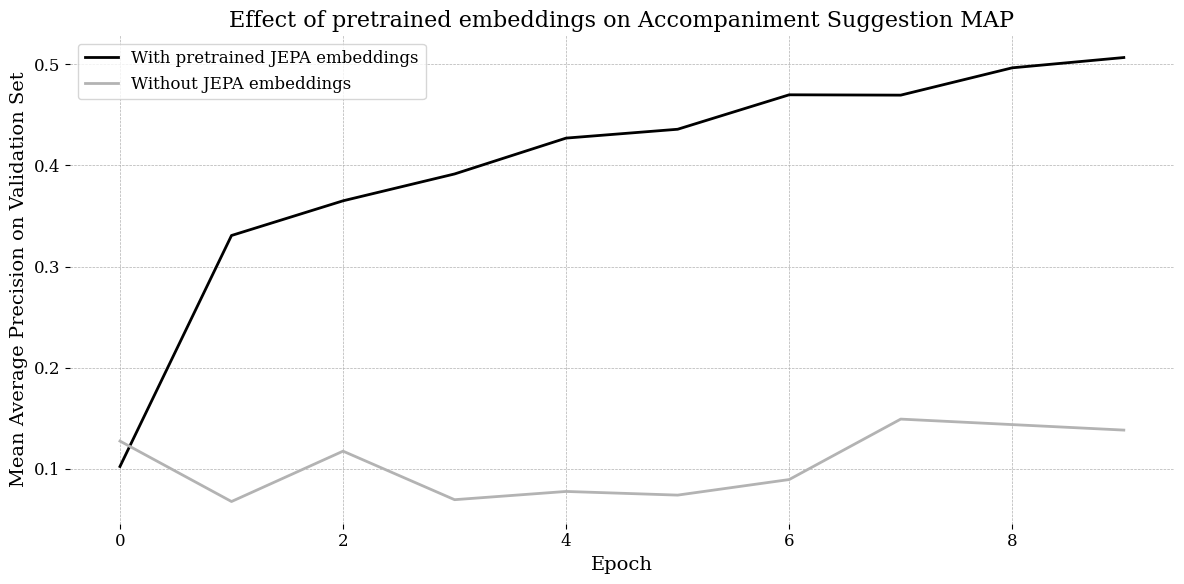

In [7]:
best_accomp_map = [x['val_map'] for x in run_metric(best_acc, 'val_map', project='symjepa-accompaniment_suggestion-classification')]

# TODO: Fix this one
untrained_accomp = 0.15 - np.array([x['val_hits_at_1'] for x in run_metric(melody_untrained, 'val_hits_at_1', project='symjepa-melody_completion-classification')])


make_plot(
    title="Effect of pretrained embeddings on Accompaniment Suggestion MAP",
    x_label='Epoch',
    y_label='Mean Average Precision on Validation Set',
    metrics=[best_accomp_map, untrained_accomp],
    labels=['With pretrained JEPA embeddings', 'Without JEPA embeddings'],
    filename='accomp_trained_vs_untrained.pdf',
)